# Market Microstructure Project
### Bid & Ask Optimization

**Ana Luisa Espinoza López**

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from functools import partial


In [14]:
import utils as u #Archivo .py con funciones de soporte

Implementation of Copeland & Galai's Model for bid and ask prices optimization. In the following project, the objective consists in implement this method in python to solve for the optimal bid & ask prices with the following parameters:

- $P ~ Erlang$($K=60$, $\lambda=3$)
- $\prod_I = 0.4$: Probability of an informed trade
- $\prod_{LB}(S) = 0.5 - 0.08S$ where $\prod_{LB}: [0, 0.5],$ and $S = (A-S_0)$
- $\prod_{LS}(S) = 0.5 - 0.08S$ where $\prod_{LS}: [0, 0.5],$ and $S = (S_0 - B)$
- $S_0 = 19.90$
- $S: [10, 33]$


### Mathematical Framework

**1. Stock Price Distribution**
The stock prices for this problem follows an Erlang distribution, where:

$f(S,K,\lambda)=\frac{\lambda^K S^{K-1}\exp^{-\lambda S}}{(K-1)!}$ for $S \in [10,33]$

<br>


**2. Expected Revenue Function** 
The expected revenue for the market maker is given by the following expression:
$$E[R] = (1-\prod_I)[\prod_{LB}(A-S_0)\cdot (A-S_0) + \prod_{LS}(S_0-B)\cdot (S_0-B)] - \prod_I [L_{buy}+L_{sell}]$$

Where the losses from the informed traders are:

$L_{buy} = \prod_{LB}(A-S_0)\int^{33}_A (S-A)\cdot f(S) dS$

$L_{sell} = \prod_{LS}(S_0-B)\int^{B}_{10} (B-S)\cdot f(S) dS$

<br>

**3. Liquidity Probability Functions**

$\prod_{LB}(S) = \max(0, min(0.5, 0.5 - 0.8S))$ where  $S = A-S_0$

$\prod_{LS}(S) = \max(0, min(0.5, 0.5 - 0.8S))$ where  $S = S_0-B$

### Plot with Price distribution

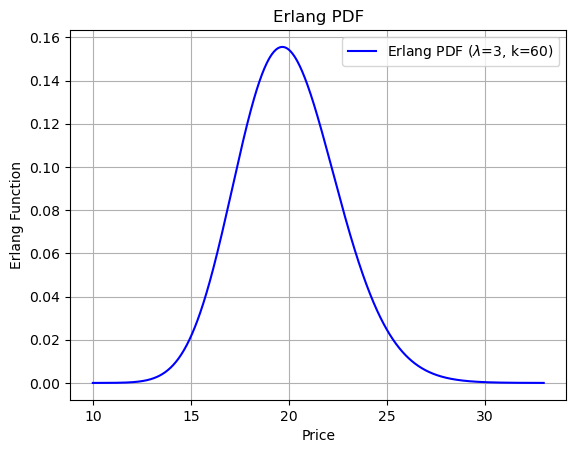

In [15]:
# Definimos el rango de valores para x
x = np.linspace(10, 33, 1000)
lambda_ = 3
k = 60

# Calculamos los valores de la función de densidad de probabilidad de Weibull
y = u.erlang_pdf(x, lambda_, k)

plt.plot(x, y, label=f'Erlang PDF ($\\lambda$={lambda_}, k={k})',color = 'blue')
plt.xlabel('Price')
plt.ylabel('Erlang Function')
plt.title('Erlang PDF')
plt.legend()
plt.grid(True)
plt.show()

### Bid, Ask and Spot price

For the optimization of the bid and ask prices, we're going to optimize the variable as a vector: $prices = [B, A]$

In [16]:
S_0 = 19.90
prices = [S_0 - 3, S_0 + 3]  # Initial guess for [B, A]
result = minimize(partial(u.utility, S0=S_0, lambda_=lambda_, k=k), prices, method='BFGS')
B_opt, A_opt = result.x
U_opt = -result.fun  

Optimal Bid Price (B): 16.78
Optimal Ask Price (A): 23.02
Maximized Expected Utility (U): 1.56


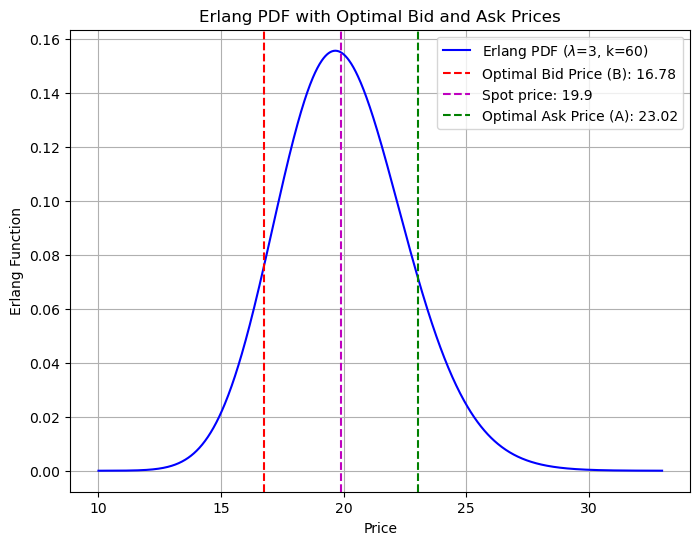

In [17]:
print(f'Optimal Bid Price (B): {B_opt:.2f}')
print(f'Optimal Ask Price (A): {A_opt:.2f}')
print(f'Maximized Expected Utility (U): {U_opt:.2f}')

# Plotting the Erlang PDF with optimal bid and ask prices
plt.figure(figsize=(8, 6))

plt.plot(x, y, label=f'Erlang PDF ($\\lambda$={lambda_}, k={k})', color='blue')
plt.axvline(B_opt, color='red', linestyle='--', label=f'Optimal Bid Price (B): {B_opt:.2f}')
plt.axvline(S_0, color='m', linestyle='--', label=f'Spot price: {S_0}')
plt.axvline(A_opt, color='green', linestyle='--', label=f'Optimal Ask Price (A): {A_opt:.2f}')
plt.xlabel('Price')
plt.ylabel('Erlang Function')
plt.title('Erlang PDF with Optimal Bid and Ask Prices')

plt.legend()
plt.grid(True)
plt.show()

### Plot with Expected revenue

The probability of an informed trade for this problem is $\prod_I = 0.4$

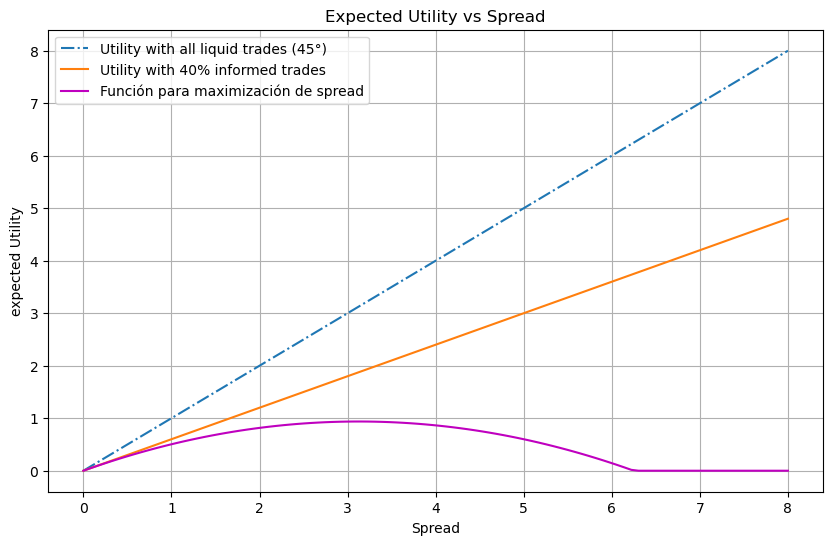

In [18]:
S = np.linspace(0, 8, 100)  # Rango de Spread values (spread value between optimal bid and ask is 6.24)
P_I = 0.4  # Probabilidad de transacción informada


# Bencmark case: all liquidity trades → lineal utility in S
E_U = S * (1 - P_I)
U_max_spread = [(s * (1 - P_I)) * (u.p_LS(s) + u.p_LB(s))  for s in S] #same probability of liquidity for buy and sell


plt.figure(figsize=(10, 6))
plt.plot(S, S, label='Utility with all liquid trades (45°)', linestyle='-.')
plt.plot(S, E_U, label=f'Utility with 40% informed trades')

plt.plot(S, U_max_spread, label = 'Función para maximización de spread', color = 'm')
plt.title('Expected Utility vs Spread')
plt.xlabel('Spread')
plt.ylabel('expected Utility')
plt.legend()
plt.grid(True)
plt.show()

En conclusión, para maximizar la utilidad mediante spreads los precios optimos de bid y ask son 16.78 y 23.02, respectivamente, cuando el spot price sea de 19.90. Por otro lado, oberservando el gráfico de utilidades, se puede concluir que la presencia de traders informados reduce la utilidad significativamente a comparación del benchmark. Finalmente, con la curva de maximización de spread muestra que spreads muy chicos generan poca utilidad y que spreads altos de igual manera desalientan a los traders de liquidez. Por ende, el market maker debe lograr un equilibrio entre atraer un flujo adecuado de operaciones y protegerse de la información privilegiada, definiendo un spread intermedio que le permita maximizar su utilidad.